In [1]:
# filter some warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import xarray as xr
import pandas as pd

import gsw
import copy
import os
import glob
import pickle

In [3]:
datapd = pd.read_csv("all_coord.csv")

In [4]:
def cal_mld(sigma0, lev = 'lev'):
    '''
    Function for calculate mld from density difference (den - den10) and depth
    Return mixed layer depth 
    '''
    b0 = sigma0[lev].where(~sigma0.isnull()).max(dim = lev) ## bottom topography
    sigma0_10 = sigma0.interp({lev: 10}) 
    ## find the deepest layer where den - den10 < 0.03
    mld0 = sigma0[lev].where(sigma0 - sigma0_10 < 0.03).max(dim = lev)
    ## find the next layer 
    mld1 = sigma0[lev].where(sigma0[lev]>mld0).min(lev)
    cal_min = sigma0.where(sigma0[lev]>=mld0).min(lev) ## density of the shallow layer (this layer den - den10 <= 0.03)
    cal_max = sigma0.where(sigma0[lev]>=mld1).min(lev) ## density of the deep layer (this layer den - den10 > 0.03)

    ## simple linear interpolation to get the depth where den - den10 = 0.03
    mld2 = (mld1 - mld0)/(cal_max - cal_min) * (sigma0_10 + 0.03 - cal_min) + mld0 
    ## if the resulting depth is larger than the deepest depth of the ocean bottom, use the bottom layer 
    mld = xr.where(mld0 >= b0, b0, mld2)
    return mld

In [5]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
cluster.adapt(minimum=1, maximum=50) 
client = Client(cluster)
client

2024-09-10 13:09:21,795 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-me2_t83u', purging
2024-09-10 13:09:21,798 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-nrhhtkqd', purging
2024-09-10 13:09:21,800 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-ypdcpicj', purging
2024-09-10 13:09:21,802 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-wdo1mcg0', purging
2024-09-10 13:09:21,803 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-7y0h8c9d', purging
2024-09-10 13:09:21,804 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-ltuoo009', purging
2024-09-10 13:09:21,807 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-zg1y7cbf', purging

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 7.61 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40769,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 7.61 GiB
Comm: tcp://127.0.0.1:35427,Total threads: 2
Dashboard: http://127.0.0.1:44247/status,Memory: 1.90 GiB
Nanny: tcp://127.0.0.1:43997,


Timed out during handshake while connecting to tcp://127.0.0.1:44245 after 30 s
Traceback (most recent call last):
  File "/home/sh/pkgs/miniconda3/envs/work/lib/python3.11/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sh/pkgs/miniconda3/envs/work/lib/python3.11/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/sh/pkgs/miniconda3/envs/work/lib/python3.11/site-packages/distributed/comm/core.py", line 328, in connect
    handshake = await asyncio.wait_for(comm.read(), time_left())
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sh/pkgs/miniconda3/envs/work/lib/pyt

In [6]:
# read netcdf files and save september southern (<-40) s&t data for further calculation
for i in range(0, len(datapd)):
    name = datapd.at[i, 'source_id'] 
    fpath = 'data_mld/' + name + '.pickle'
    print("{} {}".format(i, name))

    if pd.isna(datapd.at[i, 'xname']):
        print("    [x] no regular grid.")
        continue

    if os.path.exists(fpath):
        print('    [o] data exist.')
        continue

    data_path_s = '/mnt/d/CMIP6/so_Omon_' + name + '_piControl_' + datapd.at[i, 'member_id'] + '*' + datapd.at[i, 'grid_label'] + '*' + '.nc'
    data_path_t = '/mnt/d/CMIP6/thetao_Omon_' + name + '_piControl_' + datapd.at[i, 'member_id'] + '*' + datapd.at[i, 'grid_label'] + '*' + '.nc'
    # Get the list of files matching the search pattern
    matching_files_s = glob.glob(data_path_s)
    matching_files_t = glob.glob(data_path_t)

    matching_files_s.sort()
    matching_files_t.sort()
    
    # Check if there are any matching files
    if len(matching_files_s) == 0:
        print("    [ ] salt/temp data missing.")
        continue
    if len(matching_files_s) != len(matching_files_t):
        print('    [ ] s and t data different length.')
        continue

    if xr.open_mfdataset(matching_files_t[0], use_cftime=True).thetao.nbytes/1024/1024/1024 > 1.5: 
        print("    [ ] data too large.")
        continue

    for j in range(0, len(matching_files_s)):
        dst = xr.open_mfdataset(matching_files_t[j], use_cftime=True)
        dss = xr.open_mfdataset(matching_files_s[j], use_cftime=True)

        das = dss.so
        dat = dst.thetao

        if 'type' in das.coords:
            das = das.reset_coords('type', drop = True)
            dat = dat.reset_coords('type', drop = True)
        if (dat.time.values != das.time.values).any():
            dat = dat.assign_coords(time = das.time)
        
        levname = datapd.at[i, 'zname']      
        
        da_sigma0 = gsw.sigma0(das.where(das > 0), dat.where(dat != 0))

        if 'units' in das[levname].attrs:
            if das[levname].units == 'centimeters':
                da_sigma0[levname] = da_sigma0[levname]/100 # unit: cm --> m
        
        southlat = -50

        if pd.isna(datapd.at[i, 'latname']):
            da_south = da_sigma0.sel({datapd.at[i, 'yname']: slice(-90, southlat)})
        else:
            da_lat = da_sigma0[datapd.at[i, 'latname']].load()
            da_south = da_sigma0.where(da_lat  < southlat, drop=True)
        
        da_sep = da_south.isel(time=(da_south.time.dt.month == 9))
        da_mld = cal_mld(da_sep, levname)
        
        if j == 0:
            da_save = da_mld.load()
        else:
            da_save0 = da_mld.load()
            da_save = xr.concat([da_save, da_save0], dim="time")
    
    with open(fpath, 'wb') as wf:
        pickle.dump(da_save, wf, pickle.HIGHEST_PROTOCOL)
    print("    [*] data saved.")


0 BCC-CSM2-MR
    [o] data exist.
1 BCC-ESM1
    [o] data exist.
2 CAMS-CSM1-0
    [o] data exist.
3 ACCESS-ESM1-5
    [o] data exist.
4 ACCESS-CM2
    [o] data exist.
5 GFDL-CM4
    [o] data exist.
6 GFDL-ESM4
    [o] data exist.
7 KIOST-ESM
    [ ] data too large.
8 NESM3
    [o] data exist.
9 CanESM5
    [o] data exist.
10 CanESM5-1
    [o] data exist.
11 CanESM5-CanOE
    [o] data exist.
12 CMCC-CM2-SR5
    [o] data exist.
13 CMCC-ESM2
    [o] data exist.
14 EC-Earth3
    [o] data exist.
15 EC-Earth3-CC
    [o] data exist.
16 EC-Earth3-LR
    [o] data exist.
17 EC-Earth3-Veg
    [o] data exist.
18 EC-Earth3-Veg-LR
    [o] data exist.
19 EC-Earth3-AerChem
    [o] data exist.
20 CNRM-CM6-1
    [o] data exist.
21 CNRM-CM6-1-HR
    [o] data exist.
22 CNRM-ESM2-1
    [o] data exist.
23 HadGEM3-GC31-LL
    [o] data exist.
24 HadGEM3-GC31-MM
    [o] data exist.
25 UKESM1-0-LL
    [o] data exist.
26 UKESM1-1-LL
    [ ] data too large.
27 IPSL-CM5A2-INCA
    [o] data exist.
28 IPSL-CM6A-LR


In [9]:
# read netcdf files and save september southern (<-40) s&t data for further calculation
southlat = -50

for i in [7, 26, 29, 32]:
    name = datapd.at[i, 'source_id'] 
    fpath = 'data_mld/' + name + '.pickle'
    print("{} {}".format(i, name))

    if pd.isna(datapd.at[i, 'xname']):
        print("    [x] no regular grid.")
        continue

    if os.path.exists(fpath):
        print('    [o] data exist.')
        continue

    data_path_s = '/mnt/d/CMIP6/so_Omon_' + name + '_piControl_' + datapd.at[i, 'member_id'] + '*' + datapd.at[i, 'grid_label'] + '*' + '.nc'
    data_path_t = '/mnt/d/CMIP6/thetao_Omon_' + name + '_piControl_' + datapd.at[i, 'member_id'] + '*' + datapd.at[i, 'grid_label'] + '*' + '.nc'
    # Get the list of files matching the search pattern
    matching_files_s = glob.glob(data_path_s)
    matching_files_t = glob.glob(data_path_t)

    matching_files_s.sort()
    matching_files_t.sort()
    
    # Check if there are any matching files
    if len(matching_files_s) == 0:
        print("    [ ] salt/temp data missing.")
        continue
    if len(matching_files_s) != len(matching_files_t):
        print('    [ ] s and t data different length.')
        continue

    if xr.open_mfdataset(matching_files_t[0], use_cftime=True).thetao.nbytes/1024/1024/1024 > 1.5: 
        for j in range(0, len(matching_files_s)):
            dst = xr.open_mfdataset(matching_files_t[j], use_cftime=True)
            dss = xr.open_mfdataset(matching_files_s[j], use_cftime=True)
            
            das = dss.so
            dat = dst.thetao
            if 'type' in das.coords:
                das = das.reset_coords('type', drop = True)
                dat = dat.reset_coords('type', drop = True)
            if (dat.time.values != das.time.values).any():
                print("    [!] Time coords different")
                continue
                # dat = dat.assign_coords(time = das.time)
            levname = datapd.at[i, 'zname']

            if 'units' in das[levname].attrs:
                if das[levname].units == 'centimeters':
                    dat[levname] = dat[levname]/100 # unit: cm --> m
                    das[levname] = das[levname]/100 # unit: cm --> m

            dat_sep = dat.isel(time=(dat.time.dt.month == 9))
            das_sep = das.isel(time=(das.time.dt.month == 9))

            for t in range(len(dat_sep.time)):
                das_t = das_sep.isel(time = t)
                dat_t = dat_sep.isel(time = t)
                
                da_sigma0 = gsw.sigma0(das_t.where(das_t > 0), dat_t.where(dat_t != 0))
                
                if pd.isna(datapd.at[i, 'latname']):
                    da_south = da_sigma0.sel({datapd.at[i, 'yname']: slice(-90, southlat)})
                else:
                    da_lat = da_sigma0[datapd.at[i, 'latname']].load()
                    da_south = da_sigma0.where(da_lat  < southlat, drop=True)       
                
                da_mld = cal_mld(da_south, levname)       
                if (j == 0) & (t == 0):
                    da_save = da_mld.load()
                else:
                    da_save0 = da_mld.load()
                    da_save = xr.concat([da_save, da_save0], dim="time")
    
    with open(fpath, 'wb') as wf:
        pickle.dump(da_save, wf, pickle.HIGHEST_PROTOCOL)
    print("    [*] data saved.")


7 KIOST-ESM
    [o] data exist.
26 UKESM1-1-LL
    [o] data exist.
29 IPSL-CM6A-MR1
    [o] data exist.
32 MIROC-ES2H
    [o] data exist.


In [8]:
## For the three models with large data files: 'IPSL-CM5A2-INCA', 'GISS-E2-2-H', 'MPI-ESM-1-2-HAM'

# read netcdf files and save september southern (<-40) s&t data for further calculation
for i in range(0, len(datapd)):
    name = datapd.at[i, 'source_id'] 
    fpath = 'data_mld/' + name + '.pickle'

    if name not in ['IPSL-CM5A2-INCA', 'GISS-E2-2-H', 'MPI-ESM-1-2-HAM']:
        continue

    if os.path.exists(fpath):
        print('[o] {} exists.'.format(name))
        continue

    data_path_s = '/mnt/d/CMIP6/so_Omon_' + name + '_piControl_' + datapd.at[i, 'member_id'] + '*' + datapd.at[i, 'grid_label'] + '*' + '.nc'
    data_path_t = '/mnt/d/CMIP6/thetao_Omon_' + name + '_piControl_' + datapd.at[i, 'member_id'] + '*' + datapd.at[i, 'grid_label'] + '*' + '.nc'
    # Get the list of files matching the search pattern
    matching_files_s = glob.glob(data_path_s)
    matching_files_t = glob.glob(data_path_t)
    
    # Check if there are any matching files
    if len(matching_files_s) == 0:
        print("[ ] {}: data missing.".format(name))
        continue
    if len(matching_files_s) != len(matching_files_t):
        print('[ ] {}: s and t data different length.'.format(name))
        continue
    
    for j in range(0, len(matching_files_s)):
        dst = xr.open_mfdataset(matching_files_t[j], use_cftime=True)
        dss = xr.open_mfdataset(matching_files_s[j], use_cftime=True)

        das = dss.so
        dat = dst.thetao

        if 'type' in das.coords:
            das = das.reset_coords('type', drop = True)
            dat = dat.reset_coords('type', drop = True)
        if (dat.time.values != das.time.values).any():
            dat = dat.assign_coords(time = das.time)
        
        levname = datapd.at[i, 'zname']

        for fn in range(0, int(len(dss.so.time)/12)):
            das0 = das.isel(time = slice(int(fn*12), int((fn+1)*12)))
            dat0 = dat.isel(time = slice(int(fn*12), int((fn+1)*12)))     
            
            da_sigma0 = gsw.sigma0(das0.where(das0 > 0), dat0.where(dat0 != 0))
            if 'units' in das0[levname].attrs:
                if das0[levname].units == 'centimeters':
                    da_sigma0[levname] = da_sigma0[levname]/100 # unit: cm --> m      
            
            southlat = -50
            
            if pd.isna(datapd.at[i, 'latname']):
                da_south = da_sigma0.sel({datapd.at[i, 'yname']: slice(-90, southlat)})
            else:
                da_lat = da_sigma0[datapd.at[i, 'latname']].load()
                da_south = da_sigma0.where(da_lat  < southlat, drop=True)
            
            da_sep = da_south.isel(time=(da_south.time.dt.month == 9))
            da_mld = cal_mld(da_sep, levname)
            
            if (fn == 0) and (j ==0):
                da_save = da_mld.load()
            else:
                da_save0 = da_mld.load()
                da_save = xr.concat([da_save, da_save0], dim="time")
    
    with open(fpath, 'wb') as wf:
        pickle.dump(da_save, wf, pickle.HIGHEST_PROTOCOL)
    print("[o] {}: done.".format(name))

[o] IPSL-CM5A2-INCA exists.
[o] GISS-E2-2-H exists.
[o] MPI-ESM-1-2-HAM exists.


In [7]:
# read netcdf files and save september southern (<-40) s&t data for further calculation
i = datapd.loc[datapd['source_id'] == 'E3SM-2-0'].index[0]
name = datapd.at[i, 'source_id'] 
fpath = 'data_mld/' + name + '.pickle'

    # if os.path.exists(fpath):
    #     print('[o] {} exists.'.format(name))
    #     continue

data_path_s = '/mnt/d/CMIP6/so_Omon_' + name + '_piControl_' + datapd.at[i, 'member_id'] + '*' + datapd.at[i, 'grid_label'] + '*' + '.nc'
data_path_t = '/mnt/d/CMIP6/thetao_Omon_' + name + '_piControl_' + datapd.at[i, 'member_id'] + '*' + datapd.at[i, 'grid_label'] + '*' + '.nc'
    # Get the list of files matching the search pattern
matching_files_s = glob.glob(data_path_s)
matching_files_t = glob.glob(data_path_t)
    
if name == 'E3SM-2-0':
    # Check if there are any matching files
    if len(matching_files_s) == 0:
        print("[ ] {}: data missing.".format(name))

    if len(matching_files_s) != len(matching_files_t):
        print('[ ] {}: s and t data different length.'.format(name))

    if pd.isna(datapd.at[i, 'xname']):
        print("[x] {} doesn't have regular grid.".format(name))


    if xr.open_mfdataset(matching_files_t[0], use_cftime=True).thetao.nbytes/1024/1024/1024 > 1.5: 
        print("[ ] {}: data too large.".format(name))


    for j in range(0, len(matching_files_s)):
        dst = xr.open_mfdataset(matching_files_t[j], use_cftime=True)
        dss = xr.open_mfdataset(matching_files_s[j], use_cftime=True)

        das = dss.so
        dat = dst.thetao

        if 'type' in das.coords:
            das = das.reset_coords('type', drop = True)
            dat = dat.reset_coords('type', drop = True)
        if (dat.time.values != das.time.values).any():
            dat = dat.assign_coords(time = das.time)
        
        levname = datapd.at[i, 'zname']      
        
        da_sigma0 = gsw.sigma0(das.where(das > 0), dat.where(dat != 0))

        if 'units' in das[levname].attrs:
            if das[levname].units == 'centimeters':
                da_sigma0[levname] = da_sigma0[levname]/100 # unit: cm --> m
        
        southlat = -50

        if pd.isna(datapd.at[i, 'latname']):
            da_south = da_sigma0.sel({datapd.at[i, 'yname']: slice(-90, southlat)})
        else:
            da_lat = da_sigma0[datapd.at[i, 'latname']].load()
            da_south = da_sigma0.where(da_lat  < southlat, drop=True)
        
        da_sep = da_south.isel(time=(da_south.time.dt.month == 9))
        da_mld = cal_mld(da_sep, levname)
        
    #     if j == 0:
    #         da_save = da_mld.load()
    #     else:
    #         da_save0 = da_mld.load()
    #         da_save = xr.concat([da_save, da_save0], dim="time")
    
    # with open(fpath, 'wb') as wf:
    #     pickle.dump(da_save, wf, pickle.HIGHEST_PROTOCOL)
    # print("[o] {}: done.".format(name))


In [5]:
def newxy_fmissingxy(dx, dy):
    newx0 = dx[~np.isnan(dx).any(axis=1)][0]
    newy0 = dy[:, ~np.isnan(dy).any(axis=0)][:,0]
    newx, newy = np.meshgrid(newx0, newy0)
    x = np.where(np.isnan(dx), newx, dx)
    y = np.where(np.isnan(dy), newy, dy)
    return x, y

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
import matplotlib.path as mpath
import cmocean
import seaborn as sns
import pandas

In [7]:
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

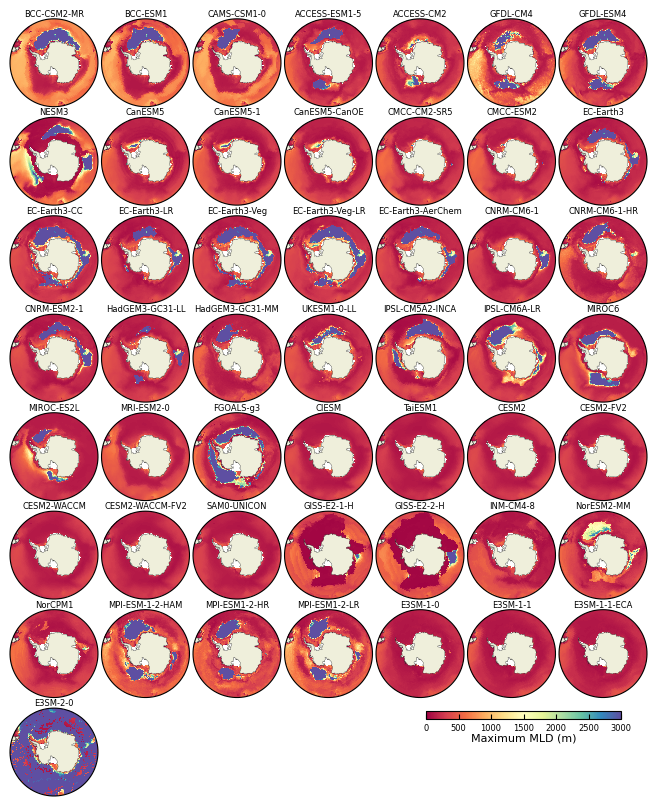

In [12]:
fig = plt.figure(figsize=(6.5,8))

n = 1

# newcmap = cmocean.tools.crop_by_percent(cmocean.cm.matter, 20, which='min', N=None)
for i in range(0, len(datapd)):
    name = datapd.at[i, 'source_id']
    pltd_name = 'data_mld/' + datapd.at[i, 'source_id'] +'.pickle'

    if os.path.exists(pltd_name):
        with open(pltd_name, 'rb') as f:
            pltd = pickle.load(f)


        ax = fig.add_subplot(8, 7, n, projection=ccrs.SouthPolarStereo())
        plt.subplots_adjust(left=0.01,
                            bottom=0.01, 
                            right=0.99, 
                            top=0.99, 
                            wspace=0.04, 
                            hspace=0.04)
        # fig.subplots_adjust(wspace=0.04, hspace=0.12)
        ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

        if name == 'NESM3':
            pltx = pltd['longitude']
            plty = pltd['latitude']
        else:
            if pd.isna(datapd.at[i, 'latname']):
                pltx0 = pltd[datapd.at[i, 'xname']]
                plty0 = pltd[datapd.at[i, 'yname']]
                pltx, plty = np.meshgrid(pltx0, plty0)
            else:
                pltx = pltd[datapd.at[i, 'lonname']]
                plty = pltd[datapd.at[i, 'latname']]

        if len(np.shape(pltx)) > 2:
            pltx = pltx.isel(time = 0)
            plty = plty.isel(time = 0)
        
        if np.isnan(pltx).any() or np.isnan(plty).any():
            pltx, plty = newxy_fmissingxy(pltx, plty)
        elif (pltx>500).any() or (plty>500).any():
            pltx = pltx.where(pltx<500)
            plty = plty.where(plty<500)
            pltx, plty = newxy_fmissingxy(pltx, plty)

        # gl = ax.gridlines(
        #     xlocs = np.arange(-180,180,90), 
        #     ylocs = np.arange(-90,90,20),
        #     draw_labels=False, y_inline=True)
            
        ax.set_title('{}'.format(datapd.at[i, 'source_id']), fontsize=6, pad=-0.5)
        
        im = ax.pcolormesh(pltx, plty, pltd.max('time'), 
                           transform=ccrs.PlateCarree(), 
                           vmin=0, vmax=3000, 
                           cmap=plt.cm.Spectral)
        
        ax.add_feature(cfeature.LAND, zorder=1)#, color='0.8')
        ax.add_feature(cfeature.COASTLINE, linewidth=0.2)
        ax.set_boundary(circle, transform=ax.transAxes)
        
        n = n+1       

        # if n > 3:
        #     break 

cbar_ax1 = fig.add_axes([0.65, 0.11, 0.30, 0.01])
cbar1 = fig.colorbar(im, cax=cbar_ax1, orientation='horizontal')
cbar1.set_label('Maximum MLD (m)', size=8, labelpad=-0.1)
cbar1.ax.tick_params(labelsize=6,direction='in')

# fig.savefig('Polynya_Multi.png', dpi = 300)


In [16]:
## for GISS only
with open('data_mld/GISS-E2-1-H.pickle', 'rb') as f:
    pltd = pickle.load(f)

pltx, plty = np.meshgrid(pltd.lon, pltd.lat)
import matplotlib.animation


plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots(figsize=(5,4))

def animate(t):
    pltd0 = pltd.isel(time = t)
    plt.cla() 
    ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
    ax.set_title(pltd0.time.values.item())
    im = ax.pcolormesh(pltx, plty, pltd0, 
                       transform=ccrs.PlateCarree(), 
                       vmin=0, vmax=2000, cmap=plt.cm.Spectral)
    ax.set_boundary(circle, transform=ax.transAxes)
    plt.colorbar(im)
    


matplotlib.animation.FuncAnimation(fig, animate, frames=len(pltd.time))

Animation size has reached 21035427 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


KeyboardInterrupt: 

In [17]:
len(pltd.time)

401

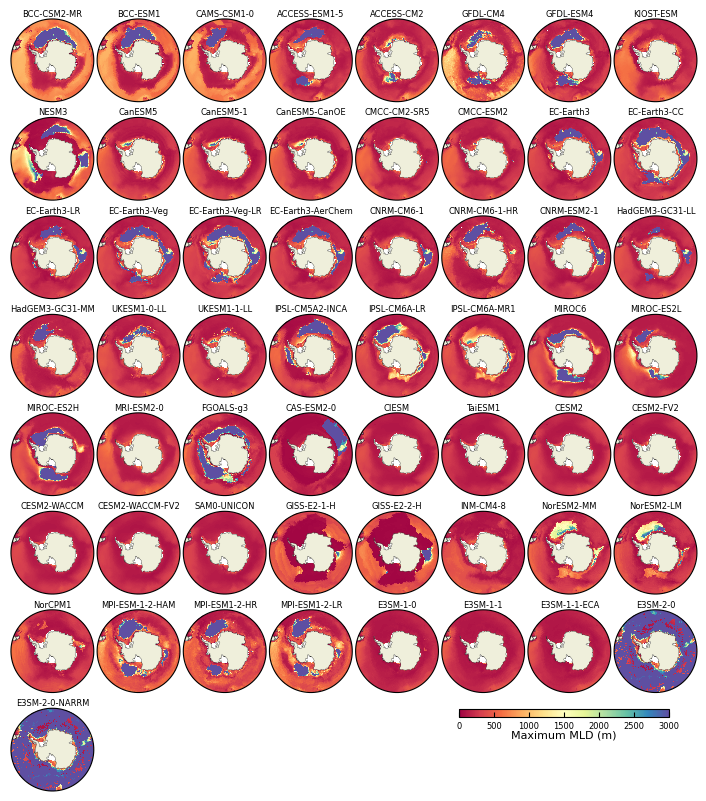

In [9]:
fig = plt.figure(figsize=(7,8))

n = 1

# newcmap = cmocean.tools.crop_by_percent(cmocean.cm.matter, 20, which='min', N=None)
for i in range(0, len(datapd)):
    name = datapd.at[i, 'source_id']
    pltd_name = 'data_mld/' + datapd.at[i, 'source_id'] +'.pickle'

    if os.path.exists(pltd_name):
        with open(pltd_name, 'rb') as f:
            pltd = pickle.load(f)


        ax = fig.add_subplot(8, 8, n, projection=ccrs.SouthPolarStereo())
        plt.subplots_adjust(left=0.01,
                            bottom=0.01, 
                            right=0.99, 
                            top=0.99, 
                            wspace=0.04, 
                            hspace=0.04)
        # fig.subplots_adjust(wspace=0.04, hspace=0.12)
        ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

        if name == 'NESM3':
            pltx = pltd['longitude']
            plty = pltd['latitude']
        else:
            if pd.isna(datapd.at[i, 'latname']):
                pltx0 = pltd[datapd.at[i, 'xname']]
                plty0 = pltd[datapd.at[i, 'yname']]
                pltx, plty = np.meshgrid(pltx0, plty0)
            else:
                if name == 'CAS-ESM2-0':
                    pltx0 = pltd['lon']
                    plty0 = pltd['lat']
                    pltx, plty = np.meshgrid(pltx0, plty0)
                else:
                    pltx = pltd[datapd.at[i, 'lonname']]
                    plty = pltd[datapd.at[i, 'latname']]

        if len(np.shape(pltx)) > 2:
            pltx = pltx.isel(time = 0)
            plty = plty.isel(time = 0)
        
        if np.isnan(pltx).any() or np.isnan(plty).any():
            pltx, plty = newxy_fmissingxy(pltx, plty)
        elif (pltx>500).any() or (plty>500).any():
            pltx = pltx.where(pltx<500)
            plty = plty.where(plty<500)
            pltx, plty = newxy_fmissingxy(pltx, plty)

        # gl = ax.gridlines(
        #     xlocs = np.arange(-180,180,90), 
        #     ylocs = np.arange(-90,90,20),
        #     draw_labels=False, y_inline=True)
            
        ax.set_title('{}'.format(datapd.at[i, 'source_id']), fontsize=6, pad=-0.5)
        
        im = ax.pcolormesh(pltx, plty, pltd.max('time'), 
                           transform=ccrs.PlateCarree(), 
                           vmin=0, vmax=3000, 
                           cmap=plt.cm.Spectral)
        
        ax.add_feature(cfeature.LAND, zorder=1)#, color='0.8')
        ax.add_feature(cfeature.COASTLINE, linewidth=0.2)
        ax.set_boundary(circle, transform=ax.transAxes)
        
        n = n+1       

        # if n > 3:
        #     break 

cbar_ax1 = fig.add_axes([0.65, 0.11, 0.30, 0.01])
cbar1 = fig.colorbar(im, cax=cbar_ax1, orientation='horizontal')
cbar1.set_label('Maximum MLD (m)', size=8, labelpad=-0.1)
cbar1.ax.tick_params(labelsize=6,direction='in')

fig.savefig('MLD_max.png', dpi = 300)
